In [353]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import caffe
import itertools as it
import pandas
import cv2
import scipy
import subprocess
import seaborn

from os.path import join as pjoin
from math import ceil
from copy import copy
from collections import OrderedDict, namedtuple, Counter
from operator import itemgetter, attrgetter
from matplotlib import pyplot
from scipy import ndimage as ndimage

from caffe import layers as L
from caffe import params as P
import tools

from ntb.layer.data import Transformer
from ntb.db import *

%matplotlib inline
# plt.style.use('fivethirtyeight')
# plt.rcParams['lines.linewidth'] = 2
# pyplot.rcParams['figure.figsize'] = (10, 6)
pyplot.rcParams['figure.figsize'] = (12, 7)

In [2]:
caffe.set_mode_gpu()

In [3]:
db = NTBDB()

In [4]:
class Network(object):
    def __init__(self, definition, weights, labels, dataset_dir, transformer):
        self.net = caffe.Net(definition, caffe.TEST, weights=weights)
        self.transformer = transformer or self._get_transformer(dataset_dir)
        self.labels = labels
        
    def _get_transformer(self, dataset_dir):
        mean_image_blob = caffe.proto.caffe_pb2.BlobProto()
        mean_image_data = open(pjoin(dataset_dir, 'mean_image.binaryproto'), 'rb' ).read()
        mean_image_blob.ParseFromString(mean_image_data)
        mean_image_arr = np.array(caffe.io.blobproto_to_array(mean_image_blob))
        mean_image_arr = mean_image_arr[0]
        mean_values = mean_image_arr.mean(1).mean(1)
        
        shape = self.net.blobs['data'].data.shape
        transformer = caffe.io.Transformer({'data': [1, shape[1], shape[2], shape[3]]})

        transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
        transformer.set_mean('data', mean_values)  # subtract the dataset-mean value in each channel
        transformer.set_raw_scale('data', 255)  # rescale from [0, 1] to [0, 255]
        transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
        return transformer
    
    def set_batch(self, batch_size):
        data_layer = self.net.blobs['data']
        shape = self.net.blobs['data'].shape
        shape[0] = batch_size
        data_layer.reshape(*shape)
        print "Set batch_size to", batch_size
    
    def get_labels(self, img_path):
        self.set_batch(1)
        image = caffe.io.load_image(img_path)
        self.net.blobs['data'].data[...][0] = self.transformer.preprocess('data', image)
        self.net.forward()
        return {label: self.net.blobs['prob'].data[0][idx] for idx, label in enumerate(self.labels)}

    def get_scores(self, indexes, batch_size=256):
        batch_size=min(len(indexes), batch_size)
        indexes = np.asarray(list(indexes))
        self.set_batch(batch_size)

        def predict_batch(batch):
            for i, index in enumerate(batch):
                image = caffe.io.load_image(db.image_path(index))
                self.net.blobs['data'].data[...][i] = self.transformer.preprocess('data', image)
            self.net.forward()

        def get_batch_scores(batch):
            res = []
            for i, index in enumerate(batch):
                row = list()
                row.insert(0, index)
                yield (index,) + tuple(self.net.blobs['score'].data[i])

        batch_num = int(ceil(indexes.size/float(batch_size)))
        scores = []
        print "Going to process", batch_num, "batches"
        for i, batch in enumerate(np.array_split(indexes, batch_num)):
            predict_batch(batch)
            scores.extend(get_batch_scores(batch))
            if i % 50 == 0:
                print "Batch", i, "finised"

        dtype = [(label, 'f4') for label in self.labels]
        dtype.insert(0, ('idx', 'S27'))
        return np.array(scores, dtype=dtype)

In [5]:
class Testing(object):
    def __init__(self, net_name, dataset_name, transformer, snapshot):
        self.net_name = net_name
        self.snapshot = snapshot
        nets_dir = pjoin("/storage/nets")
        self.net_dir = pjoin(nets_dir, self.net_name)
        self.data_dir = pjoin(self.net_dir, 'data')
        self.dataset_name = dataset_name
        self.log_path = pjoin(self.net_dir, 'logs', 'train.log')
        datasets_dir = "/storage/datasets"
        self.dataset_dir = pjoin(datasets_dir, dataset_name)
        self.labels = np.load(pjoin(self.dataset_dir, 'labels.np'))
        with open(pjoin(self.dataset_dir, 'test_raw.pickle')) as test_file:
            self.test_data = pickle.load(test_file)
            assert set(self.test_data.keys()) == set(self.labels)
        self.net = Network(
                pjoin(self.net_dir, 'testnet.prototxt'),
                pjoin(self.net_dir, 'snapshots', 'snapshot_iter_{}.caffemodel'.format(self.snapshot)),
                self.labels,
                self.dataset_dir,
                transformer,
        )
    
    def _get_scores_cached(self, batch_size):
        scores_file_path = pjoin(self.data_dir, 'scores_{}.np'.format(self.snapshot))
        try:
            with open(scores_file_path) as scores_file:
                print "Scores are restored from {}".format(scores_file_path)
                return np.load(scores_file)
        except IOError:
            indexes = set(it.chain.from_iterable(self.test_data.values()))
            scores = self.net.get_scores(indexes, batch_size=batch_size)

            with open(scores_file_path, mode='w') as scores_file:
                scores.dump(scores_file)
                print "Scores are dumped to {}".format(scores_file_path)
            return scores

    def calculate(self, batch_size=256):
        self.scores = self._get_scores_cached(batch_size)
        curves = get_curves(self.labels, self.scores, self.test_data)
        self.curves = {}
        for label in self.labels:
            self.curves[label] = pandas.DataFrame(curves[label])
        print 'Curves calculated'

        average_precision = get_average_precision(curves)
        ap_data = {
            'size': [len(self.test_data[label]) for label in self.labels],
            'ap': [average_precision[label] for label in self.labels],
        }
        self.average_precision = pandas.DataFrame(ap_data, index=list(self.labels)).sort_values('ap', ascending=False)

    def plot_average_precision_vs_size(self, with_labels=True):
        ap = self.average_precision.copy()
        ap['size'] *= 3
        ax = ap.plot('size', 'ap', kind='scatter', s=50, figsize=(12,7))
        def annotate_df(row):
            ax.annotate(row.name, (row['size'], row['ap']),
                        xytext=(10,-2), 
                        textcoords='offset points',
                        size=10,
                        color='darkslategrey')
        if with_labels:
            _ = ap.apply(annotate_df, axis=1)
        ax.set_xlabel('Sample size')
        ax.set_ylabel('Average precision')
    
    def plot_average_precision(self):
        ax = self.average_precision.plot(kind='bar', y='ap', legend=False)
        ax.set_ylabel('Average precision')
        
    def plot_precision_recall_curve(self, label):
        ax = self.curves[label].plot(x='recall', y='precision', legend=False)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
    
    def show_top_labels(self, index, num=5):
        scores = self.scores[self.scores['idx'] == index][self.labels].copy().view('f4')
        top = scores.argsort()[::-1][:num]
        image = caffe.io.load_image(db.image_path(index))
        image = scipy.misc.imresize(image, [227, 227])
        
        plt.figure()
        plt.imshow(image)
        plt.title('{}\nEST: {}'.format(index, zip(scores[top], self.labels[top])))
        plt.axis('off')
    
    def show_top_pictures(self, label, num=5):
        indexes = np.sort(self.scores, order=[label], axis=0)[['idx']][::-1].copy().view('S27')[:num]
        for index in indexes:
            self.show_top_labels(index)

    def plot_training_curve(self, xlim=None, ylim=None):
        #Parsing training/validation logs
        command = '/work/caffe/tools/extra/parse_log.sh ' + self.log_path
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, cwd=os.path.dirname(self.log_path))
        process.wait()
        #Read training and test logs
        train_log_path = self.log_path + '.train'
        test_log_path = self.log_path + '.test'
        train_log = pandas.read_csv(train_log_path, delim_whitespace=True)
        test_log = pandas.read_csv(test_log_path, delim_whitespace=True)

        fig, ax1 = plt.subplots()

        #Plotting training and test losses
        train_loss, = ax1.plot(train_log['#Iters'], train_log['TrainingLoss'])#, color='red')
        test_loss, = ax1.plot(test_log['#Iters'], test_log['TestAccuracy'])#, color='green')

        if xlim is not None:
            xmin, xmax = xlim
            ax1.set_xlim(xmin=xmin, xmax=xmax)
        if ylim is not None:
            ymin, ymax = ylim
            ax1.set_ylim(ymin=ymin, ymax=ymax)

        ax1.set_xlabel('Iteration', fontsize=15)
        ax1.set_ylabel('Loss', fontsize=15)
        ax1.tick_params(labelsize=15)
        #Adding legend
        plt.legend([train_loss, test_loss], ['Training Loss', 'Validation Loss'],  bbox_to_anchor=(1, 0.8))
#         plt.title('Training Curve', fontsize=18)
        return plt.show()

In [6]:
def get_curves(labels, scores, ground_truth):
    def get_label_curve(label):
        sorted_images = np.flipud(scores[['idx']][scores.argsort(order=[label], axis=0)]).copy().view('S27')
        is_in_ground_truth = np.vectorize(lambda i: i in ground_truth[label])
        true_positives = np.cumsum(is_in_ground_truth(sorted_images)).astype(np.float)
        precision = true_positives / np.arange(1, true_positives.size+1)
        recall = true_positives / len(ground_truth[label])

        return np.core.records.fromarrays([precision,recall], names='precision,recall')

    return {label: get_label_curve(label) for label in labels}

In [7]:
def get_average_precision(curves):
    recall_range = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    res = {}
    for label, label_curve in curves.iteritems():
        s = 0.0
        for recall in recall_range:
            s += label_curve[label_curve['recall'] >= recall]['precision'].max()
        res[label] = s / len(recall_range)
    return res

In [8]:
def show_image_with_labels(net, image_path, num_labels=5):
    labels = net.get_labels(image_path)
    image = caffe.io.load_image(image_path)
    image = scipy.misc.imresize(image, [227, 227])

    plt.figure()
    plt.imshow(image)
    labels_str = ', '.join("{}:{:.2f}".format(label, prob) for label, prob in sorted(labels.items(), key=itemgetter(1), reverse=True)[:num_labels])
    plt.title(labels_str)
    plt.axis('off')

# Sigmoid loss function, no augmentation, raw dataset, Adam solver

In [7]:
ft_sigmoid_noaug_allpics = Testing("ft_sigmoid_noaug_allpics", Transformer(shape=[227,227]), 1000)
ft_sigmoid_noaug_allpics.calculate()

Scores are restored from /storage/ntb/nets/ft_sigmoid_noaug_allpics/data/scores_1000.np


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


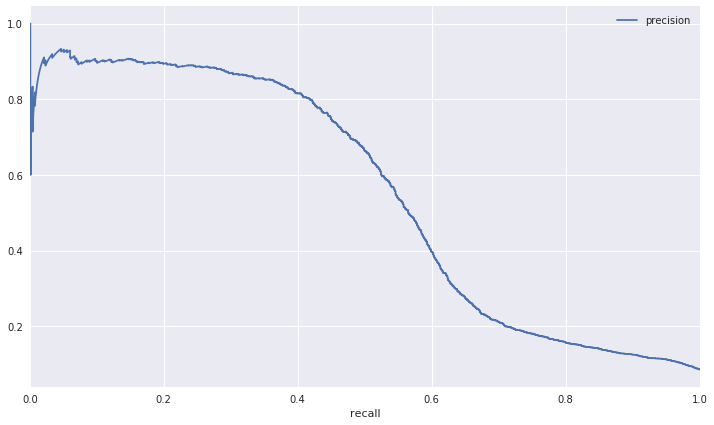

In [8]:
ft_sigmoid_noaug_allpics.plot_precision_recall_curve('football')

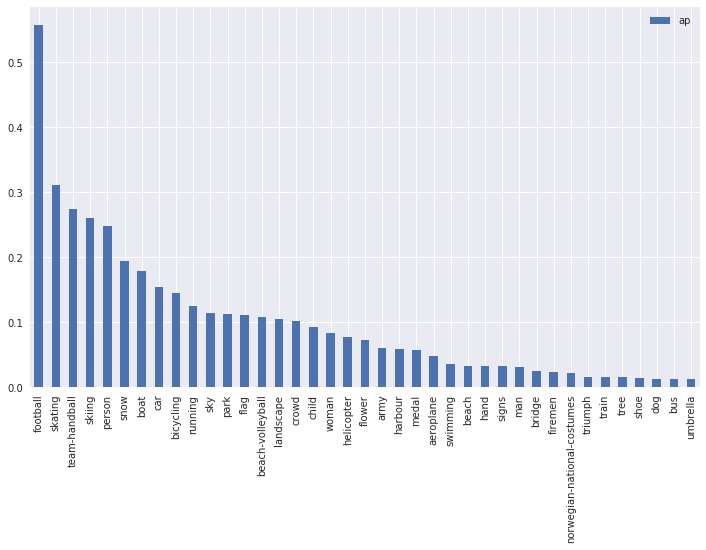

In [9]:
ft_sigmoid_noaug_allpics.plot_average_precision()

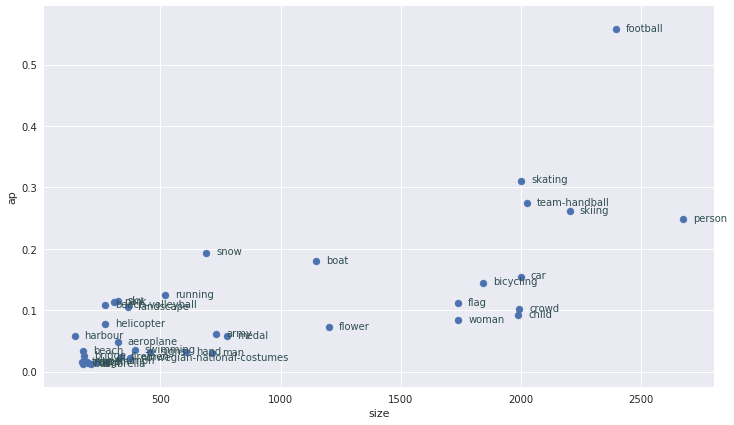

In [10]:
ft_sigmoid_noaug_allpics.plot_average_precision_vs_size()

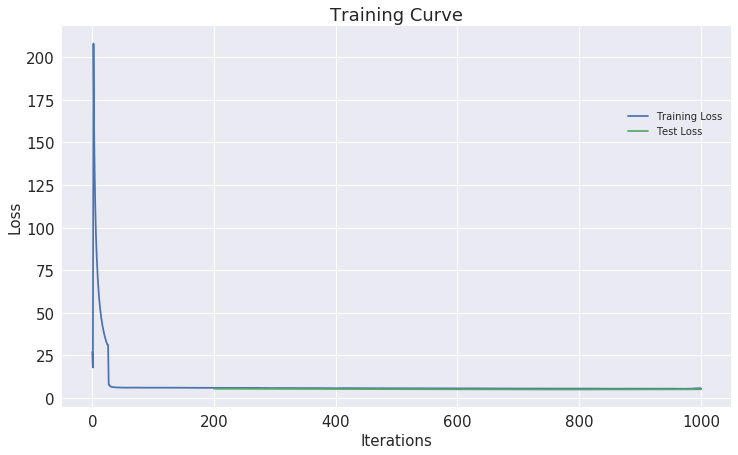

In [11]:
ft_sigmoid_noaug_allpics.plot_training_curve()

# Sigmoid loss function, no augmentation, raw dataset, SGD solver

In [12]:
ft_sigmoid_noaug_allpics_sgd = Testing("ft_sigmoid_noaug_allpics_sgd", Transformer(shape=[227,227]), 1000)
ft_sigmoid_noaug_allpics_sgd.calculate()

Scores are restored from /storage/ntb/nets/ft_sigmoid_noaug_allpics_sgd/data/scores_1000.np


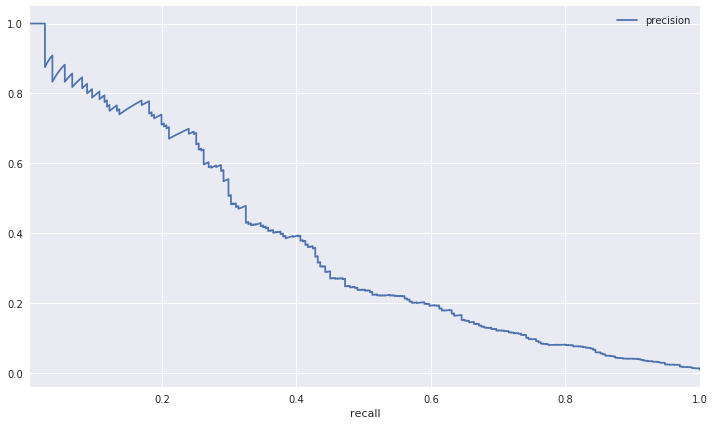

In [13]:
ft_sigmoid_noaug_allpics_sgd.plot_precision_recall_curve('helicopter')

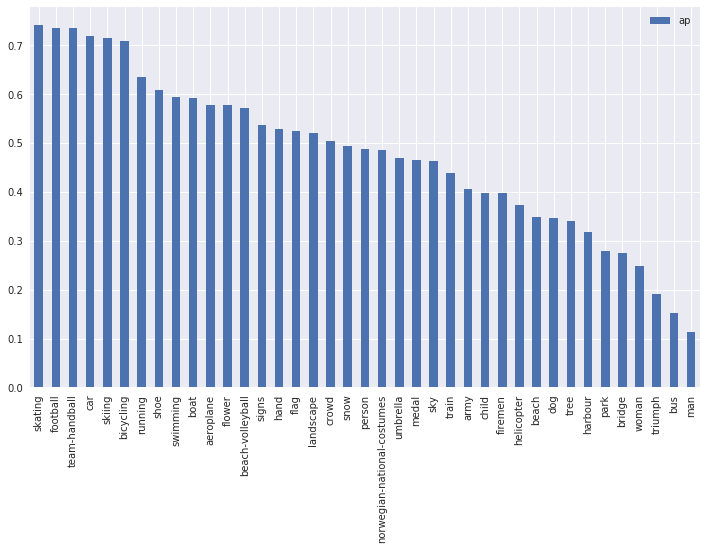

In [14]:
ft_sigmoid_noaug_allpics_sgd.plot_average_precision()

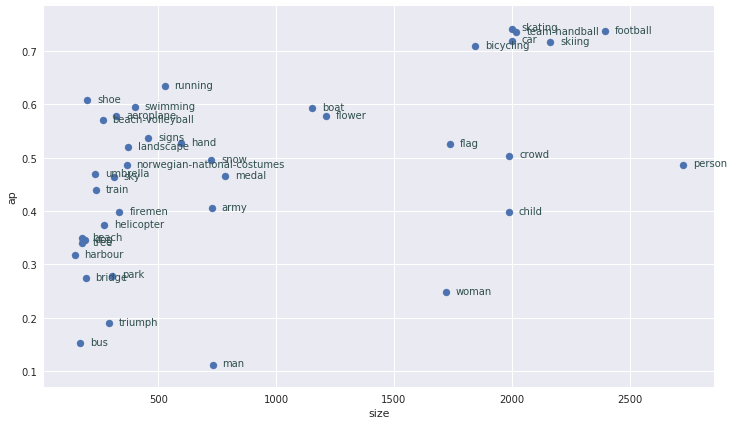

In [15]:
ft_sigmoid_noaug_allpics_sgd.plot_average_precision_vs_size()

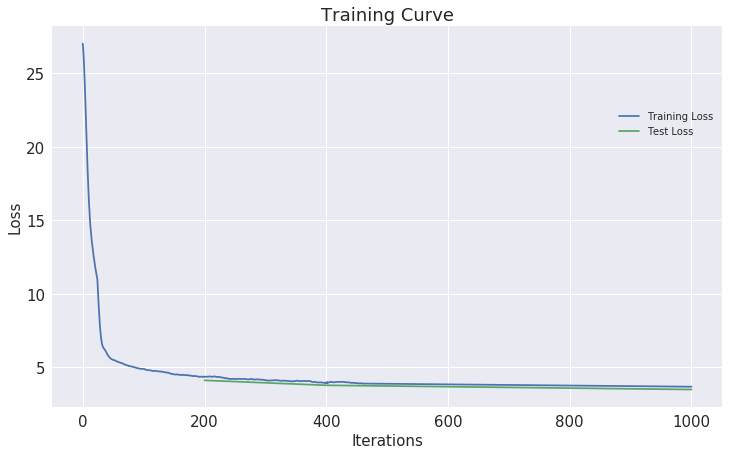

In [16]:
ft_sigmoid_noaug_allpics_sgd.plot_training_curve()

In [ ]:
ft_sigmoid_noaug_allpics_sgd.show_top_pictures('medal', num=5)

# Sigmoid loss function, no augmentation, portraits removed, SGD solver

In [18]:
ft_sigmoid_noaug_rmportraits_sgd = Testing("ft_sigmoid_noaug_rmportraits_sgd", Transformer(shape=[227,227]), 1000)
ft_sigmoid_noaug_rmportraits_sgd.calculate()

Scores are restored from /storage/ntb/nets/ft_sigmoid_noaug_rmportraits_sgd/data/scores_1000.np


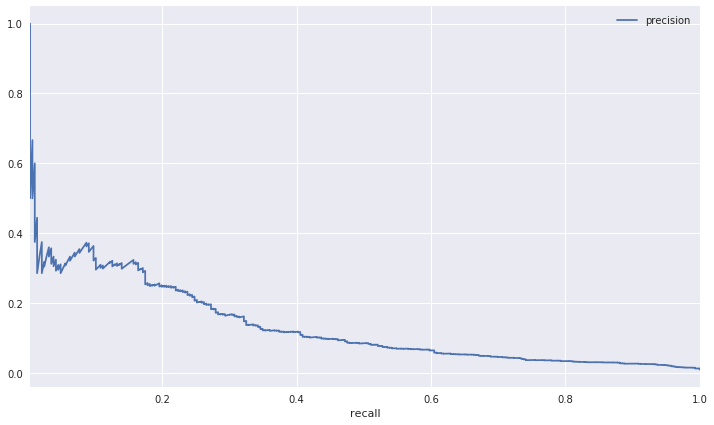

In [19]:
ft_sigmoid_noaug_rmportraits_sgd.plot_precision_recall_curve('triumph')

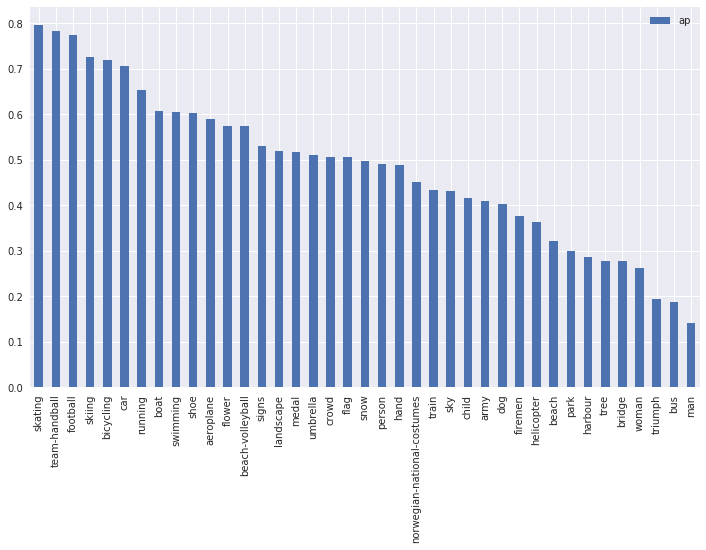

In [20]:
ft_sigmoid_noaug_rmportraits_sgd.plot_average_precision()

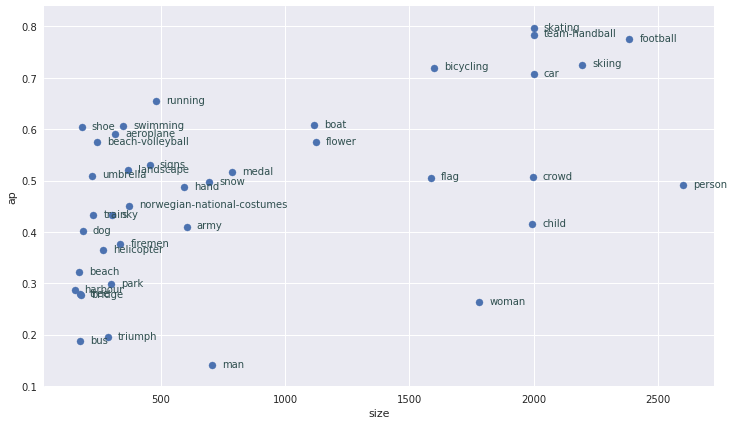

In [21]:
ft_sigmoid_noaug_rmportraits_sgd.plot_average_precision_vs_size()

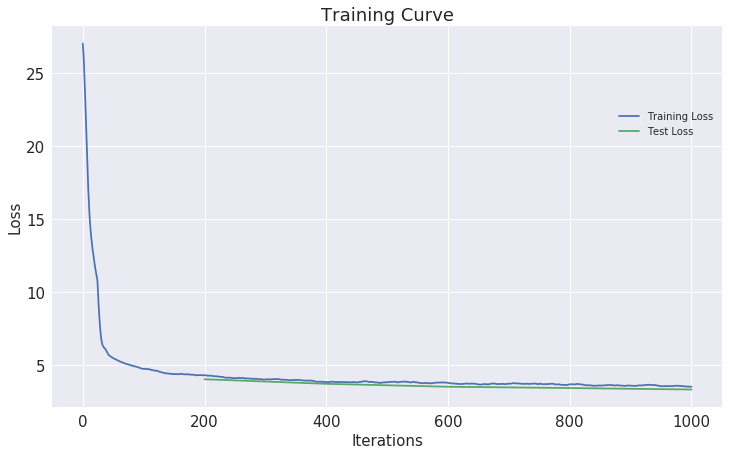

In [22]:
ft_sigmoid_noaug_rmportraits_sgd.plot_training_curve()

In [ ]:
ft_sigmoid_noaug_rmportraits_sgd.show_top_pictures('firemen', num=5)

# Sigmoid loss function, no augmentation, portraits removed, Adam solver

In [ ]:
%%time
ft_sigmoid_noaug_rmportraits_adam = Testing("ft_sigmoid_noaug_rmportraits_adam", Transformer(shape=[227,227]), 1000)
ft_sigmoid_noaug_rmportraits_adam.calculate()

Set batch_size to 256
Going to process 109 batches
Batch 0 finised
Batch 50 finised


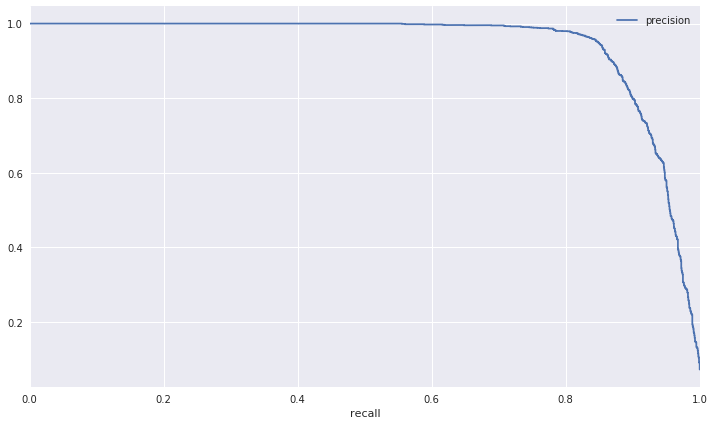

In [31]:
ft_sigmoid_noaug_rmportraits_adam.plot_precision_recall_curve('skating')

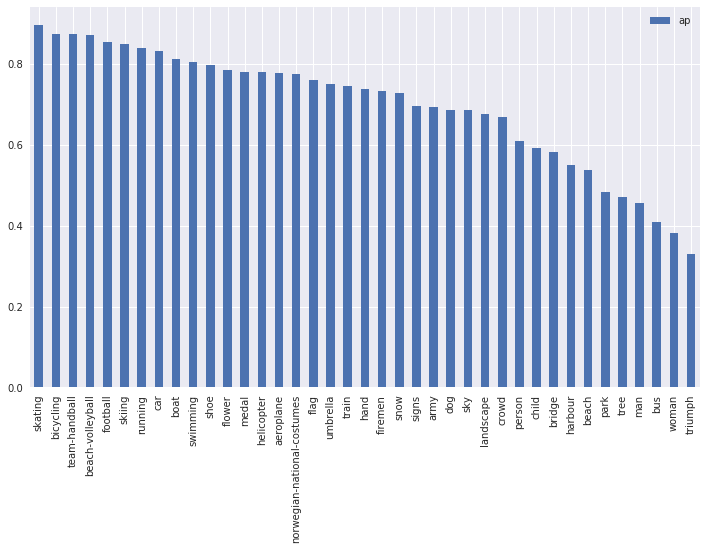

In [32]:
ft_sigmoid_noaug_rmportraits_adam.plot_average_precision()

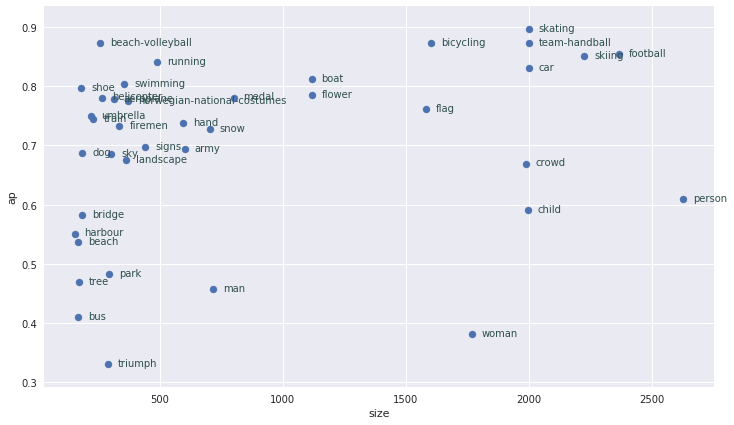

In [33]:
ft_sigmoid_noaug_rmportraits_adam.plot_average_precision_vs_size()

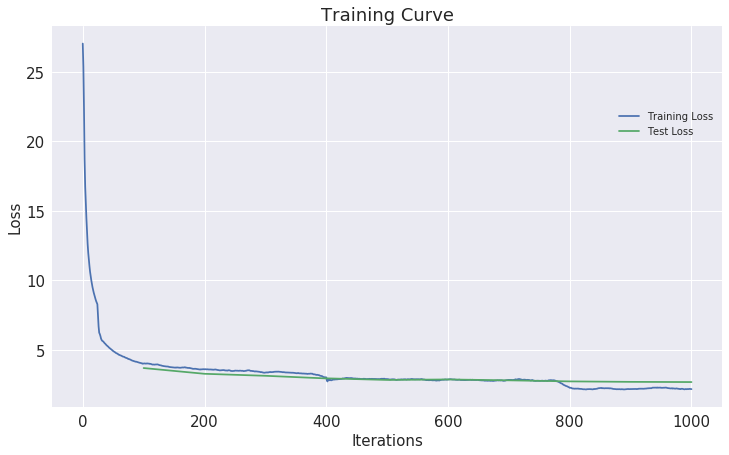

In [49]:
ft_sigmoid_noaug_rmportraits_adam.plot_training_curve()

In [ ]:
ft_sigmoid_noaug_rmportraits_adam.show_top_pictures('crowd', num=20)

# Comparison

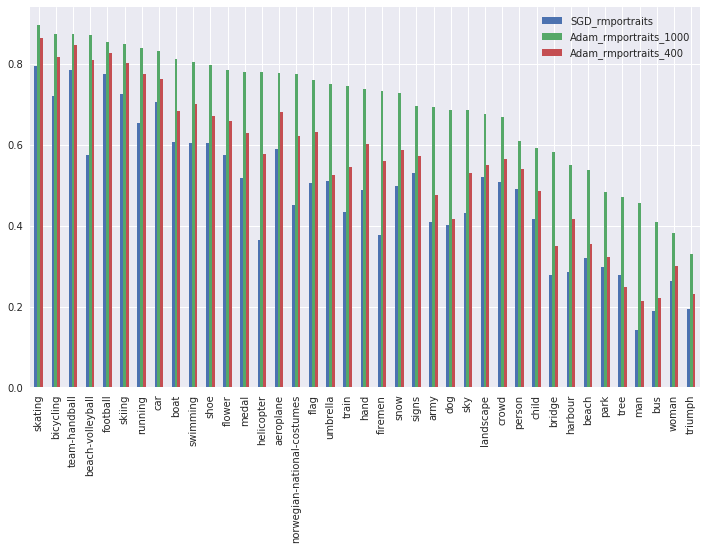

In [38]:
compare_ap = pandas.concat([
#     ft_sigmoid_noaug_allpics_sgd.average_precision,
    ft_sigmoid_noaug_rmportraits_sgd.average_precision,
    ft_sigmoid_noaug_rmportraits_adam.average_precision,
    ft_sigmoid_noaug_rmportraits_adam_400.average_precision,
], keys=['SGD_rmportraits', 'Adam_rmportraits_1000', 'Adam_rmportraits_400'])
compare_ap.unstack(level=0).sort_values([('ap', 'Adam_rmportraits_1000')], ascending=False).plot(kind='bar', y='ap',) #color=['royalblue','lightseagreen', ])

# Skiing

In [9]:
# class NetworkSM(object):
#     def __init__(self, definition, weights, labels, _):
#         self.net = caffe.Net(definition, caffe.TEST, weights=weights)
#         self.labels = labels
    
#     def set_batch(self, batch_size):
#         data_layer = self.net.blobs['data']
#         shape = self.net.blobs['data'].shape
#         shape[0] = batch_size
#         data_layer.reshape(*shape)
#         print "Set batch_size to", batch_size

#     def get_scores(self, indexes, batch_size=256):
#         batch_size=min(len(indexes), batch_size)
#         indexes = np.asarray(list(indexes))
#         self.set_batch(batch_size)
#         def transform_img(img, img_width=227, img_height=227):
#             img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
#             img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
#             img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

#             #Image Resizing
#             img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

#             return np.rollaxis(img, 2)

#         def predict_batch(batch):
#             for i, index in enumerate(batch):
#                 image = cv2.imread(db.image_path(index), cv2.IMREAD_COLOR)
#                 self.net.blobs['data'].data[...][i] = transform_img(image)
#             self.net.forward()

#         def get_batch_scores(batch):
#             res = []
#             for i, index in enumerate(batch):
#                 row = list()
#                 row.insert(0, index)
#                 yield (index,) + tuple(self.net.blobs['score'].data[i])

#         batch_num = int(ceil(indexes.size/float(batch_size)))
#         scores = []
#         print "Going to process", batch_num, "batches"
#         for i, batch in enumerate(np.array_split(indexes, batch_num)):
#             predict_batch(batch)
#             scores.extend(get_batch_scores(batch))
#             if i % 50 == 0:
#                 print "Batch", i, "finised"

#         dtype = [(label, 'f4') for label in self.labels]
#         dtype.insert(0, ('idx', 'S27'))
#         return np.array(scores, dtype=dtype)
    
# class TestingSM(object):
#     def __init__(self, net_name, transformer, snapshot):
#         self.net_name = net_name
#         self.transformer = transformer
#         self.snapshot = snapshot
#         nets_dir = pjoin("/storage/nets")
#         self.net_dir = pjoin(nets_dir, self.net_name)
#         self.data_dir = pjoin(self.net_dir, 'data')
#         self.log_path = pjoin(self.net_dir, 'logs', 'train.log')
#         self.labels = np.load(pjoin(self.data_dir, 'labels.np'))
#         with open(pjoin(self.data_dir, 'test_raw.pickle')) as test_file:
#             self.test_data = pickle.load(test_file)
#             assert set(self.test_data.keys()) == set(self.labels)
#         self.net = NetworkSM(
#                 pjoin(self.net_dir, 'testnet.prototxt'),
#                 pjoin(self.net_dir, 'snapshots', 'snapshot_iter_{}.caffemodel'.format(self.snapshot)),
#                 self.labels,
#                 self.transformer,
#         )
    
#     def _get_scores_cached(self, batch_size):
#         scores_file_path = pjoin(self.data_dir, 'scores_{}.np'.format(self.snapshot))
#         try:
#             with open(scores_file_path) as scores_file:
#                 print "Scores are restored from {}".format(scores_file_path)
#                 return np.load(scores_file)
#         except IOError:
#             indexes = set(it.chain.from_iterable(self.test_data.values()))
#             scores = self.net.get_scores(indexes, batch_size=batch_size)

#             with open(scores_file_path, mode='w') as scores_file:
#                 scores.dump(scores_file)
#                 print "Scores are dumped to {}".format(scores_file_path)
#             return scores

#     def calculate(self, batch_size=256):
#         self.scores = self._get_scores_cached(batch_size)
#         curves = get_curves(self.labels, self.scores, self.test_data)
#         self.curves = {}
#         for label in self.labels:
#             self.curves[label] = pandas.DataFrame(curves[label])

#         average_precision = get_average_precision(curves)
#         ap_data = {
#             'size': [len(self.test_data[label]) for label in self.labels],
#             'ap': [average_precision[label] for label in self.labels],
#         }
#         self.average_precision = pandas.DataFrame(ap_data, index=list(self.labels)).sort_values('ap', ascending=False)

#     def plot_average_precision_vs_size(self):
#         ax = self.average_precision.plot('size', 'ap', kind='scatter', s=50, figsize=(12,7))
#         def annotate_df(row):
#             ax.annotate(row.name, (row['size'], row['ap']),
#                         xytext=(10,-2), 
#                         textcoords='offset points',
#                         size=10,
#                         color='darkslategrey')

#         _ = self.average_precision.apply(annotate_df, axis=1) # with labels
    
#     def plot_average_precision(self):
#         self.average_precision.plot(kind='bar', y='ap')
        
#     def plot_precision_recall_curve(self, label):
#         self.curves[label].plot(x='recall', y='precision')
    
#     def show_top_labels(self, index, num=5):
#         scores = self.scores[self.scores['idx'] == index][self.labels].copy().view('f4')
#         top = scores.argsort()[::-1][:num]
#         image = caffe.io.load_image(image_path(db.metadata[index]))
#         image = scipy.misc.imresize(image, [227, 227])
        
#         plt.figure()
#         plt.imshow(image)
#         plt.title('{}\nEST: {}'.format(index, zip(scores[top], self.labels[top])))
#         plt.axis('off')
    
#     def show_top_pictures(self, label, num=5):
#         indexes = np.sort(self.scores, order=[label], axis=0)[['idx']][::-1].copy().view('S27')[:num]
#         for index in indexes:
#             self.show_top_labels(index)

#     def plot_training_curve(self, xlim=None, ylim=None):
#         #Parsing training/validation logs
#         command = '/work/caffe/tools/extra/parse_log.sh ' + self.log_path
#         process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, cwd=os.path.dirname(self.log_path))
#         process.wait()
#         #Read training and test logs
#         train_log_path = self.log_path + '.train'
#         test_log_path = self.log_path + '.test'
#         train_log = pandas.read_csv(train_log_path, delim_whitespace=True)
#         test_log = pandas.read_csv(test_log_path, delim_whitespace=True)

#         fig, ax1 = plt.subplots()

#         #Plotting training and test losses
#         train_loss, = ax1.plot(train_log['#Iters'], train_log['TrainingLoss'], color='red')
#         test_loss, = ax1.plot(test_log['#Iters'], test_log['TestAccuracy'], color='green')

#         if xlim is not None:
#             xmin, xmax = xlim
#             ax1.set_xlim(xmin=xmin, xmax=xmax)
#         if ylim is not None:
#             ymin, ymax = ylim
#             ax1.set_ylim(ymin=ymin, ymax=ymax)

#         ax1.set_xlabel('Iterations', fontsize=15)
#         ax1.set_ylabel('Loss', fontsize=15)
#         ax1.tick_params(labelsize=15)
#         #Adding legend
#         plt.legend([train_loss, test_loss], ['Training Loss', 'Test Loss'],  bbox_to_anchor=(1, 0.8))
#         plt.title('Training Curve', fontsize=18)
#         return plt.show()

In [10]:
%%time
ft_softmax_noaug_skiing_adam = TestingSM("ft_softmax_noaug_skiing_adam", Transformer(shape=[227,227]), 1000)
ft_softmax_noaug_skiing_adam.calculate(batch_size=1024)

Set batch_size to 1024
Going to process 7 batches
Batch 0 finised
Scores are dumped to /storage/nets/ft_softmax_noaug_skiing_adam/data/scores_1000.np
CPU times: user 6min 5s, sys: 37.7 s, total: 6min 42s
Wall time: 4min 35s


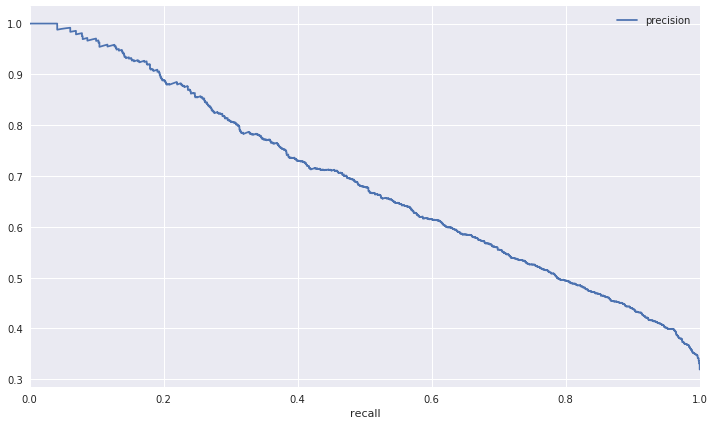

In [12]:
ft_softmax_noaug_skiing_adam.plot_precision_recall_curve('biathlon')

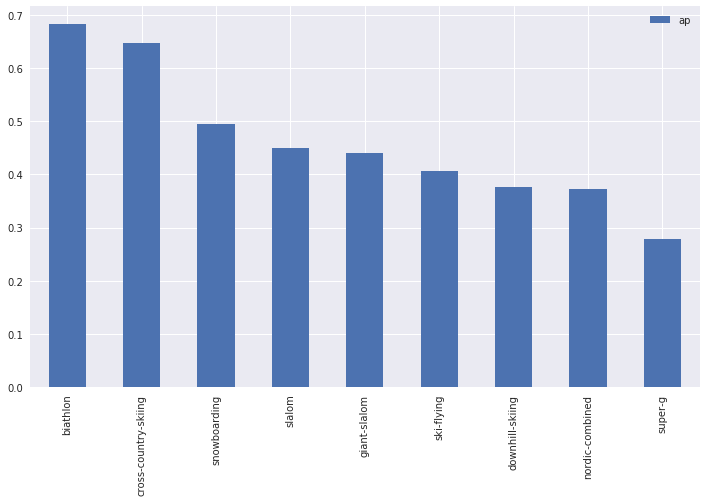

In [13]:
ft_softmax_noaug_skiing_adam.plot_average_precision()

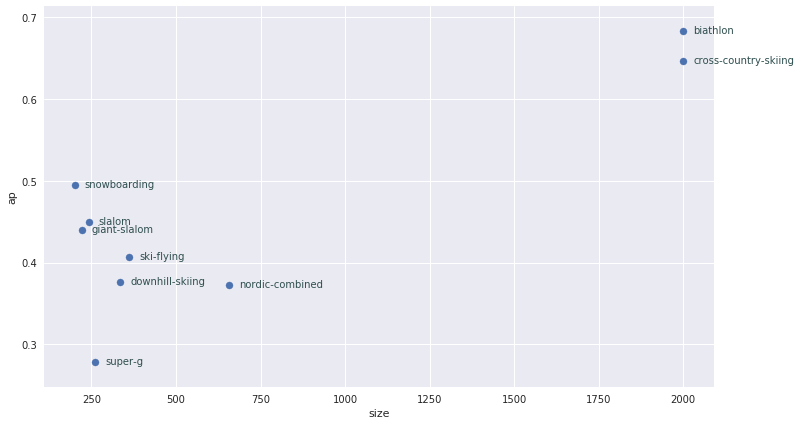

In [14]:
ft_softmax_noaug_skiing_adam.plot_average_precision_vs_size()

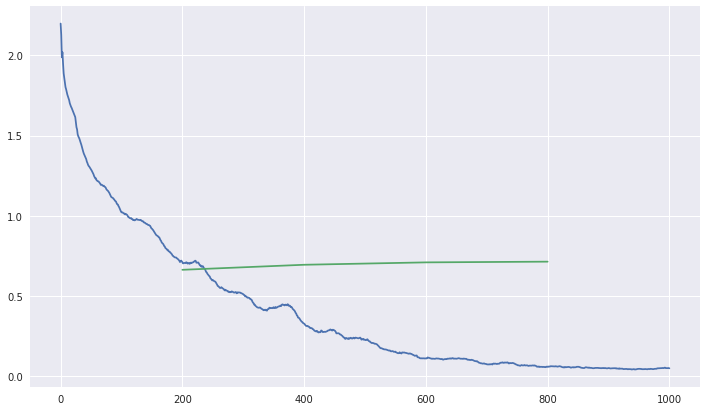

In [19]:
command = '/work/caffe/tools/extra/parse_log.sh ' + ft_softmax_noaug_skiing_adam.log_path
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, cwd=os.path.dirname(ft_softmax_noaug_skiing_adam.log_path))
process.wait()
#Read training and test logs
train_log_path = ft_softmax_noaug_skiing_adam.log_path + '.train'
test_log_path = ft_softmax_noaug_skiing_adam.log_path + '.test'
train_log = pandas.read_csv(train_log_path, delim_whitespace=True)
test_log = pandas.read_csv(test_log_path, delim_whitespace=True)

fig, ax1 = plt.subplots()

# print train_log['#Iters'], train_log['TrainingLoss']

# #Plotting training and test losses
train_loss, = ax1.plot(train_log['#Iters'], train_log['TrainingLoss'])#, color='red')
test_loss, = ax1.plot(test_log['#Iters'], test_log['TestAccuracy'])#, color='green')

# Raw dataset, Caffenet, 50 images threshold

In [ ]:
%%time
raw_50_ft_caffenet_adam_1000 = Testing('raw_50_ft_caffenet_adam', 'raw_50', None, 1000)
raw_50_ft_caffenet_adam_1000.calculate(batch_size=2048)

Scores are restored from /storage/nets/raw_50_ft_caffenet_adam/data/scores_1000.np


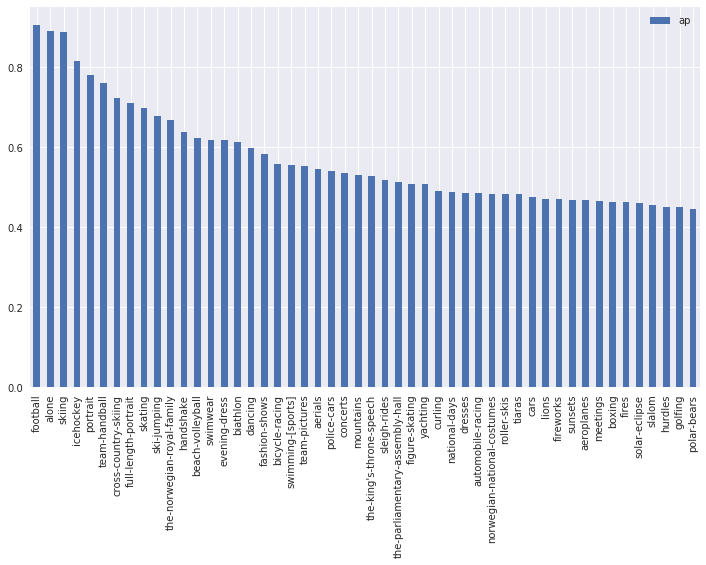

In [40]:
raw_50_ft_caffenet_adam_1000.average_precision.head(50).plot(kind='bar', y='ap')

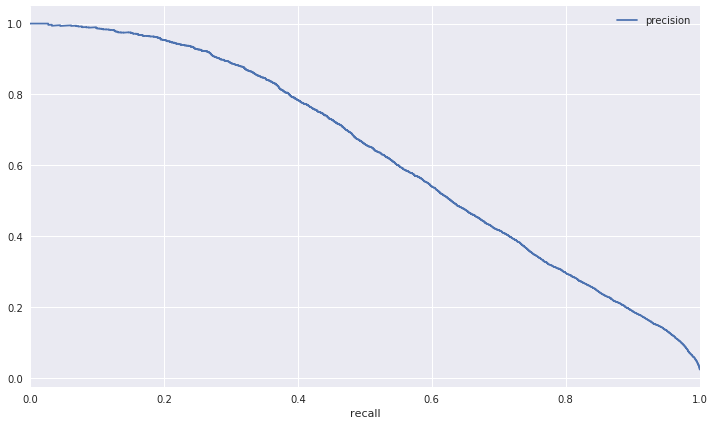

In [18]:
raw_50_ft_caffenet_adam_1000.plot_precision_recall_curve('biathlon')

In [ ]:
raw_50_ft_caffenet_adam_1000.show_top_pictures('chess', 10)

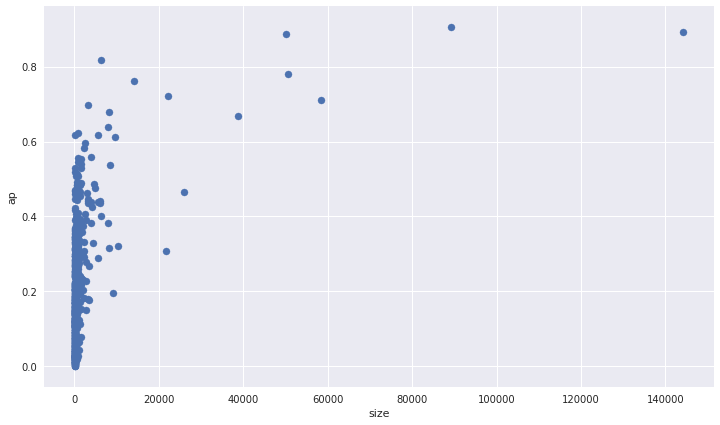

In [46]:
raw_50_ft_caffenet_adam_1000.average_precision.sort_values('size').head(1000).plot('size', 'ap', kind='scatter', s=50, figsize=(12,7))

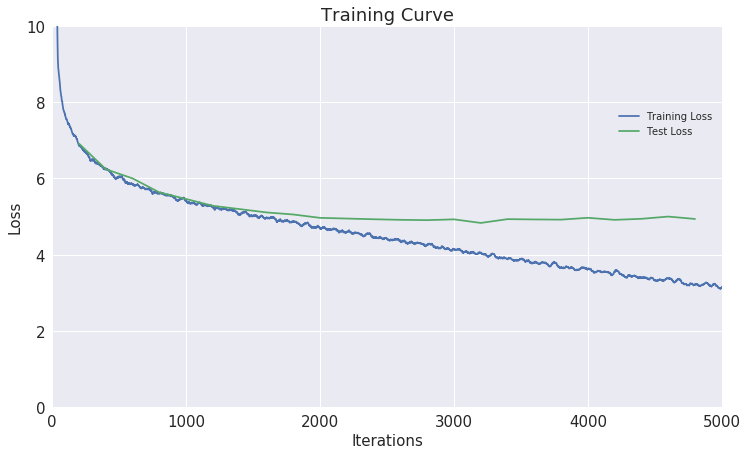

In [125]:
raw_50_ft_caffenet_adam_3000.plot_training_curve(xlim=(0,5000), ylim=(0,10))

In [16]:
%%time
raw_50_ft_caffenet_adam_2500 = Testing('raw_50_ft_caffenet_adam', 'raw_50', None, 2500)
raw_50_ft_caffenet_adam_2500.calculate(batch_size=2500)

Scores are restored from /storage/nets/raw_50_ft_caffenet_adam/data/scores_2500.np
Curves calculated
CPU times: user 9min 15s, sys: 6.1 s, total: 9min 21s
Wall time: 9min 22s


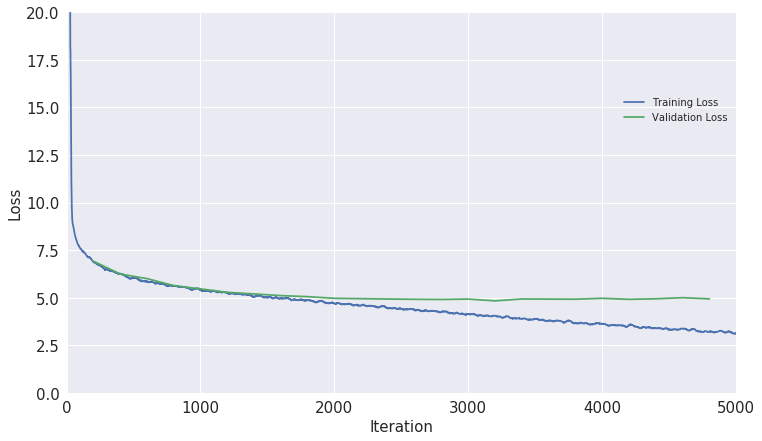

In [39]:
raw_50_ft_caffenet_adam_2500.plot_training_curve(xlim=(0,5000), ylim=(0,20))

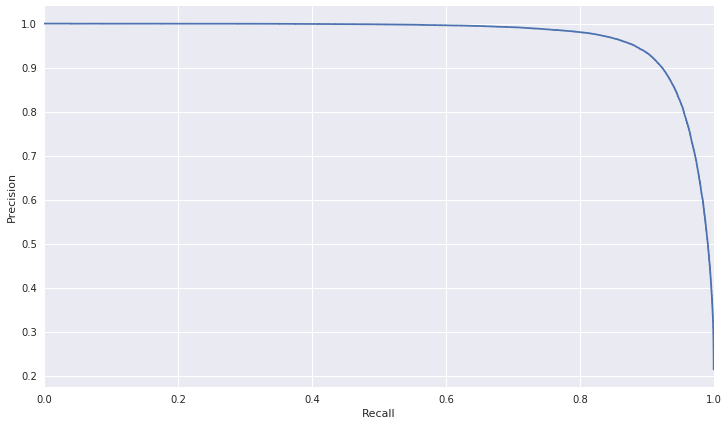

In [12]:
raw_50_ft_caffenet_adam_2500.plot_precision_recall_curve('football')

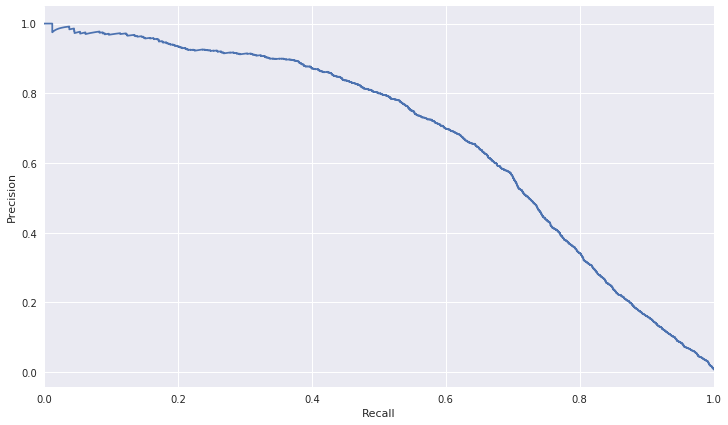

In [32]:
raw_50_ft_caffenet_adam_2500.plot_precision_recall_curve('medals')

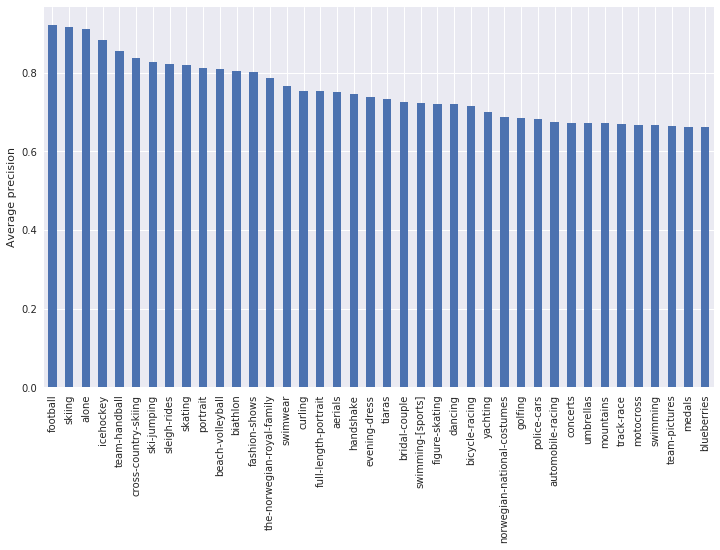

In [19]:
ax = raw_50_ft_caffenet_adam_2500.average_precision.head(40).plot(kind='bar', y='ap', legend=False)
ax.set_ylabel('Average precision')

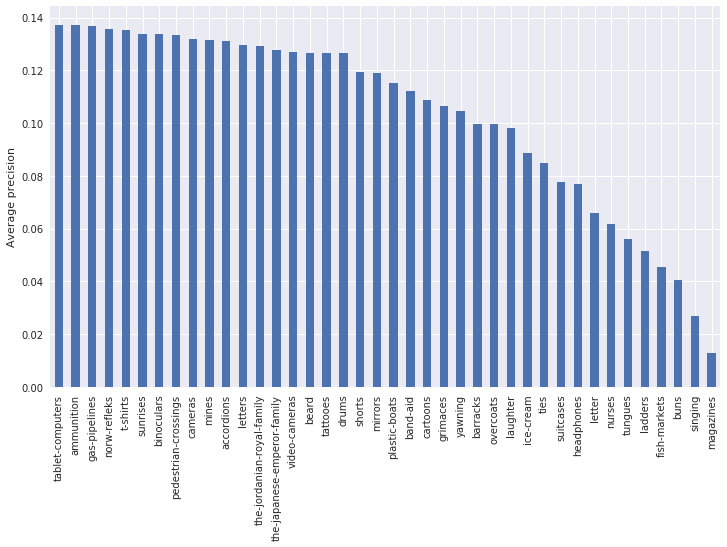

In [31]:
ax = raw_50_ft_caffenet_adam_2500.average_precision.tail(40).plot(kind='bar', y='ap', legend=False)
ax.set_ylabel('Average precision')

In [30]:
raw_50_ft_caffenet_adam_2500.average_precision[raw_50_ft_caffenet_adam_2500.average_precision['ap'] > 0.6].count()

ap      74
size    74
dtype: int64

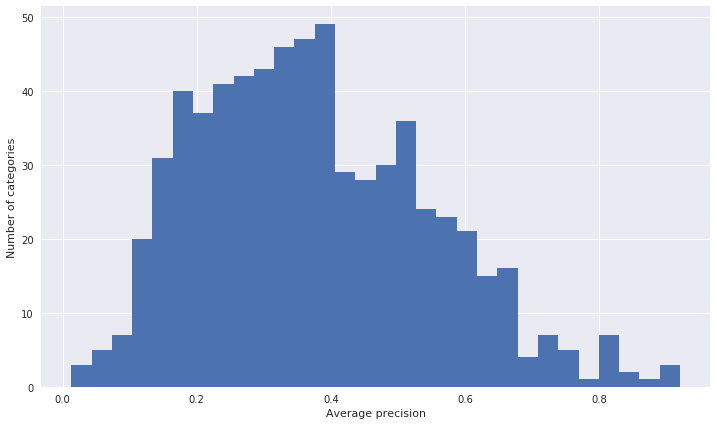

In [56]:
ax = raw_50_ft_caffenet_adam_2500.average_precision['ap'].hist(bins=30)
ax.set_xlabel('Average precision')
ax.set_ylabel('Number of categories')

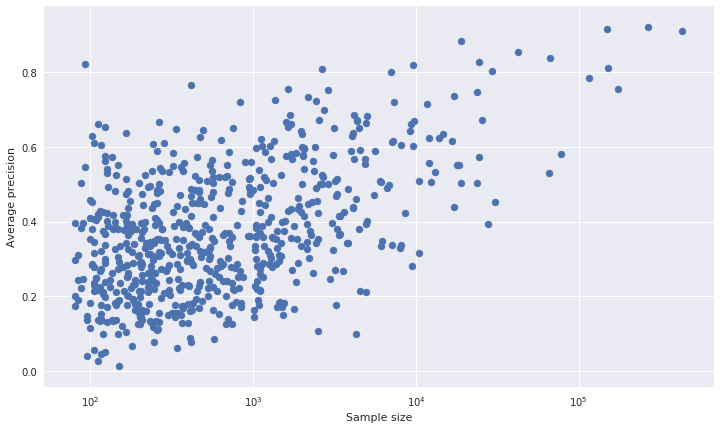

In [32]:
# raw_50_ft_caffenet_adam_2500.plot_average_precision_vs_size(with_labels=False)
ap = raw_50_ft_caffenet_adam_2500.average_precision.copy()
ap['size'] *= 3
ax = ap.plot('size', 'ap', kind='scatter', s=50, figsize=(12,7), logx=True)
ax.set_xlabel('Sample size')
ax.set_ylabel('Average precision')

In [9]:
%%time
raw_50_ft_caffenet_adam_3000 = Testing('raw_50_ft_caffenet_adam', 'raw_50', None, 3000)
raw_50_ft_caffenet_adam_3000.calculate(batch_size=2048)

Scores are restored from /storage/nets/raw_50_ft_caffenet_adam/data/scores_3000.np
Curves calculated
CPU times: user 8min 25s, sys: 6.26 s, total: 8min 32s
Wall time: 8min 33s


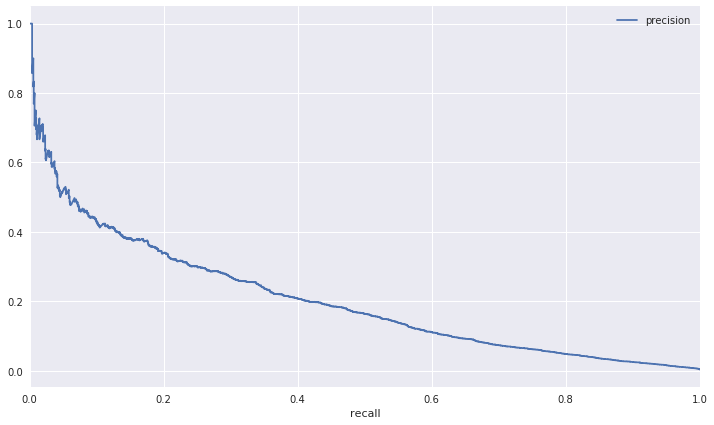

In [11]:
raw_50_ft_caffenet_adam_3000.plot_precision_recall_curve('sign-of-triumph')

In [ ]:
raw_50_ft_caffenet_adam_3000.show_top_pictures('sign-of-triumph', 10)

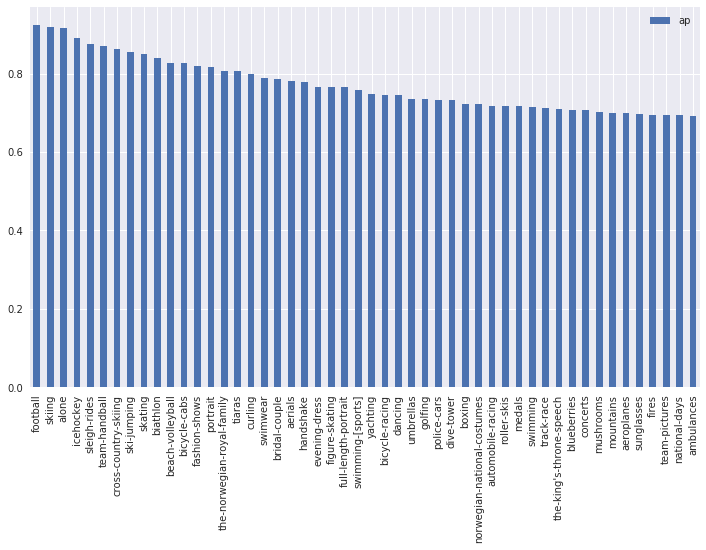

In [127]:
raw_50_ft_caffenet_adam_3000.average_precision.head(50).plot(kind='bar', y='ap')

In [ ]:
raw_50_ft_caffenet_adam_3000.show_top_pictures('dancing', 3)

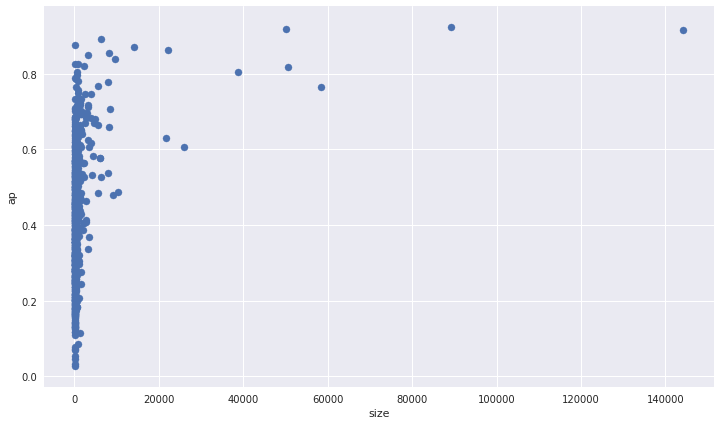

In [22]:
raw_50_ft_caffenet_adam_3000.plot_average_precision_vs_size(with_labels=False)

In [165]:
n = Network(
                pjoin(raw_50_ft_caffenet_adam_3000.net_dir, 'testnet.prototxt'),
                pjoin(raw_50_ft_caffenet_adam_3000.net_dir, 'snapshots', 'snapshot_iter_{}.caffemodel'.format(raw_50_ft_caffenet_adam_3000.snapshot)),
                raw_50_ft_caffenet_adam_3000.labels,
                raw_50_ft_caffenet_adam_3000.dataset_dir,
                None,
        )

In [ ]:
show_image_with_labels(n, '/storage/imgs/test/biathlon/1.jpg', 8)

# Raw dataset, GoogleNet, 50 images threshold

In [9]:
%%time
raw_50_ft_googlenet_adam_35000 = Testing('raw_50_ft_googlenet_adam', 'raw_50', None, 35000)
raw_50_ft_googlenet_adam_35000.calculate(batch_size=320)

Set batch_size to 320
Going to process 1305 batches
Batch 0 finised
Batch 50 finised
Batch 100 finised
Batch 150 finised
Batch 200 finised
Batch 250 finised
Batch 300 finised
Batch 350 finised
Batch 400 finised
Batch 450 finised
Batch 500 finised
Batch 550 finised
Batch 600 finised
Batch 650 finised
Batch 700 finised
Batch 750 finised
Batch 800 finised
Batch 850 finised
Batch 900 finised
Batch 950 finised
Batch 1000 finised
Batch 1050 finised
Batch 1100 finised
Batch 1150 finised
Batch 1200 finised
Batch 1250 finised
Batch 1300 finised
Scores are dumped to /storage/nets/raw_50_ft_googlenet_adam/data/scores_35000.np
Curves calculated
CPU times: user 1h 3min 57s, sys: 47min 57s, total: 1h 51min 54s
Wall time: 1h 3min 36s


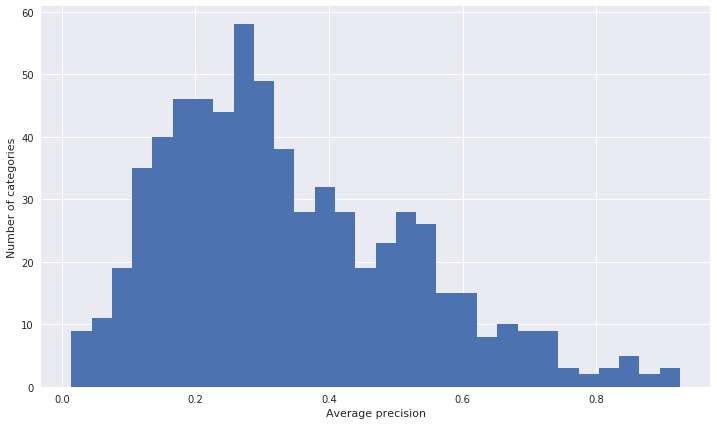

In [12]:
ax = raw_50_ft_googlenet_adam_35000.average_precision['ap'].hist(bins=30)
ax.set_xlabel('Average precision')
ax.set_ylabel('Number of categories')

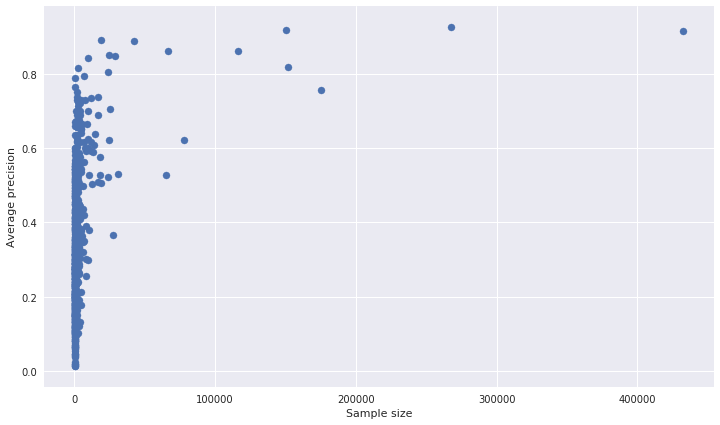

In [13]:
raw_50_ft_googlenet_adam_35000.plot_average_precision_vs_size(with_labels=False)

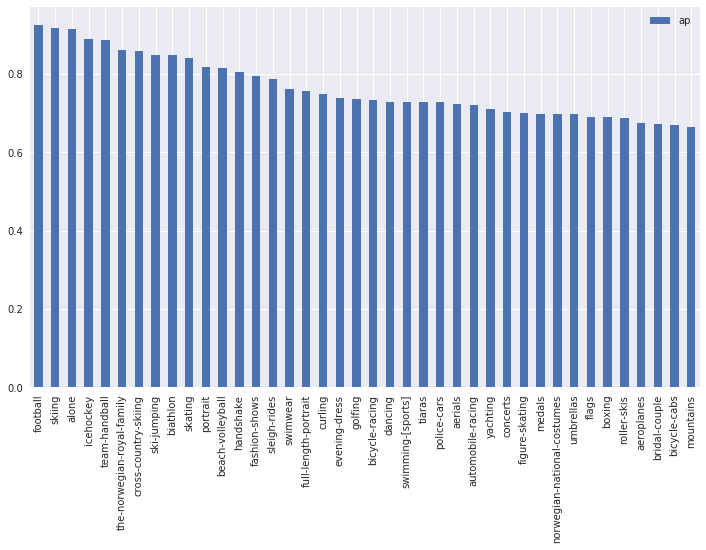

In [258]:
raw_50_ft_googlenet_adam_35000.average_precision.head(40).plot(kind='bar', y='ap')

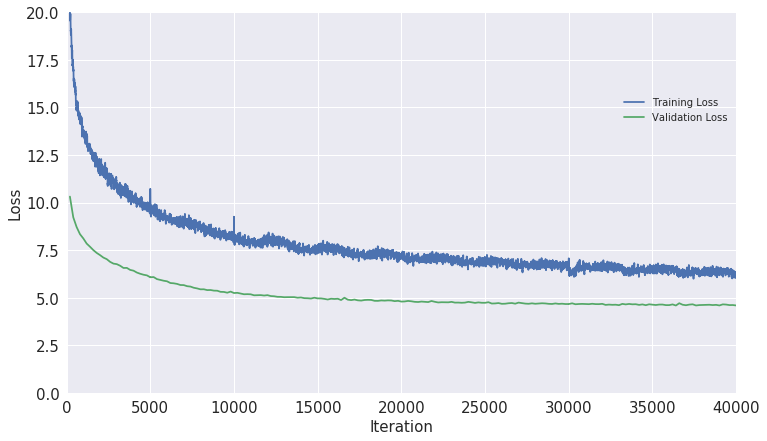

In [17]:
raw_50_ft_googlenet_adam_30000.plot_training_curve(ylim=(0,20), xlim=(0, 40000))#xlim=(0, 31000), ylim=(0, 15))

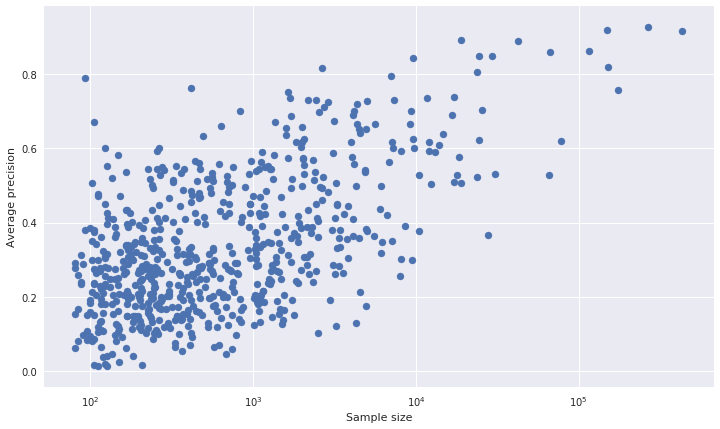

In [15]:
# raw_50_ft_caffenet_adam_2500.plot_average_precision_vs_size(with_labels=False)
ap = raw_50_ft_googlenet_adam_35000.average_precision.copy()
ap['size'] *= 3
ax = ap.plot('size', 'ap', kind='scatter', s=50, figsize=(12,7), logx=True)
ax.set_xlabel('Sample size')
ax.set_ylabel('Average precision')

# Comparison raw

In [236]:
compare_ap = pandas.concat([
    raw_50_ft_caffenet_adam_2500.average_precision,
    raw_50_ft_googlenet_adam_35000.average_precision,
], keys=['CaffeNet', 'GoogleNet'])
df = compare_ap.unstack(level=0).sort_values([('size', 'GoogleNet')], ascending=False)[:50]#.sort_values([('ap', 'GoogleNet')]).plot('size', 'ap', kind='scatter')#[['ap']].plot(kind='hist', bins=40, alpha=0.8)
len(df[(df['ap']['GoogleNet'] > df['ap']['CaffeNet'])]) / float(len(df))

0.74

In [136]:
labels = ['football', 'the-norwegian-royal-family', 'blueberries', 'medals', 'distance-running']
for label in labels:
    print label, ":", len(raw_50_ft_caffenet_adam_2500.test_data[label])

football : 89215
the-norwegian-royal-family : 38795
blueberries : 37
medals : 3105
distance-running : 687


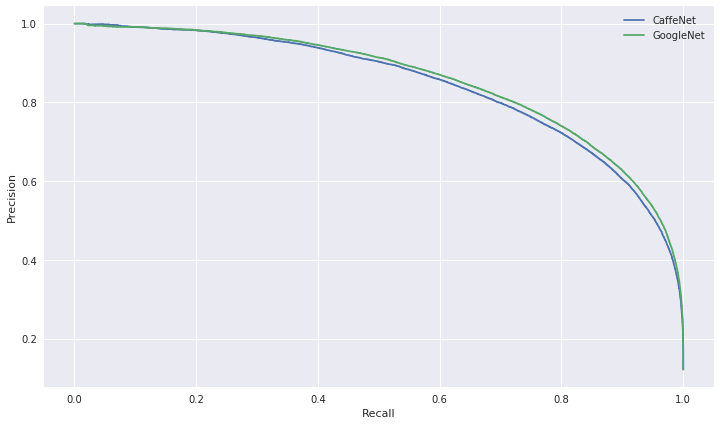

In [279]:
label = 'portrait'
plt.plot(raw_50_ft_caffenet_adam_2500.curves[label]['recall'], raw_50_ft_caffenet_adam_2500.curves[label]['precision'], label='CaffeNet')
plt.plot(raw_50_ft_googlenet_adam_35000.curves[label]['recall'], raw_50_ft_googlenet_adam_35000.curves[label]['precision'], label='GoogleNet')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

In [263]:
best_caffe = raw_50_ft_caffenet_adam_2500.average_precision.sort_values(['ap'], ascending=False)[:40].index
best_google = raw_50_ft_googlenet_adam_35000.average_precision.sort_values(['ap'], ascending=False)[:40].index
worst_caffe = raw_50_ft_caffenet_adam_2500.average_precision.sort_values(['ap'], ascending=True)[:40].index
(raw_50_ft_googlenet_adam_35000.average_precision.ix[best_caffe]['ap'] > raw_50_ft_caffenet_adam_2500.average_precision.ix[best_caffe]['ap']).sum()

26

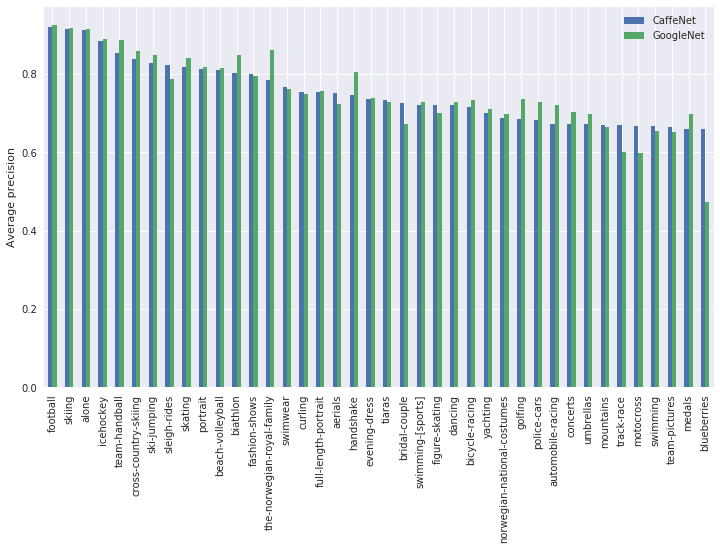

In [239]:
compare_ap = pandas.concat([
    raw_50_ft_caffenet_adam_2500.average_precision,
    raw_50_ft_googlenet_adam_35000.average_precision,
], keys=['CaffeNet', 'GoogleNet'])
ax = compare_ap.unstack(level=0).sort_values([('ap', 'CaffeNet')], ascending=False).head(40).plot(kind='bar', y='ap',) #color=['royalblue','lightseagreen', ])
ax.set_ylabel('Average precision')

In [416]:
print "CaffeNet: mean", raw_50_ft_caffenet_adam_2500.average_precision['ap'].mean(), "std:", raw_50_ft_caffenet_adam_2500.average_precision['ap'].std()
print "GoogleNet: mean", raw_50_ft_googlenet_adam_35000.average_precision['ap'].mean(), "std:", raw_50_ft_googlenet_adam_35000.average_precision['ap'].std()

CaffeNet: mean 0.37504675251 std: 0.17251801143
GoogleNet: mean 0.33965798584 std: 0.183874452069


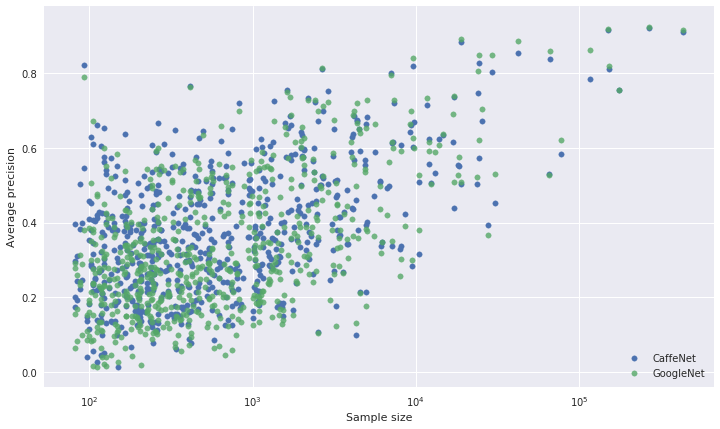

In [235]:
ap_gn = raw_50_ft_googlenet_adam_35000.average_precision.copy()
ap_cn = raw_50_ft_caffenet_adam_2500.average_precision.copy()
ap_gn['size'] *= 3
ap_cn['size'] *= 3
plt.scatter(ap_cn['size'], ap_cn['ap'], s=30, label='CaffeNet')
plt.scatter(ap_gn['size'], ap_gn['ap'], s=30, label='GoogleNet', alpha=0.8)
plt.xscale('log')
plt.legend(loc=4)
plt.xlabel('Sample size')
plt.ylabel('Average precision')

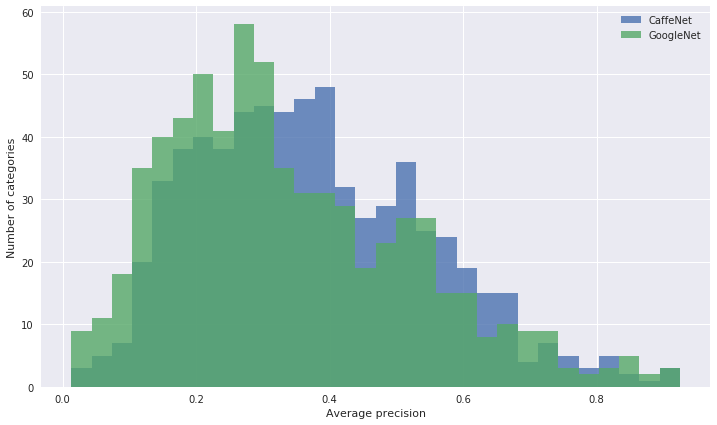

In [70]:
ax = pandas.DataFrame({
    'CaffeNet': raw_50_ft_caffenet_adam_2500.average_precision['ap'],
    'GoogleNet': raw_50_ft_googlenet_adam_35000.average_precision['ap'],
}).plot(kind='hist', bins=30, alpha=0.8)
ax.set_xlabel('Average precision')
ax.set_ylabel('Number of categories')

In [ ]:
%%time
raw_50_ft_googlenet_adam_10000 = Testing('raw_50_ft_googlenet_adam', 'raw_50', None, 10000)
raw_50_ft_googlenet_adam_10000.calculate(batch_size=256)

Set batch_size to 256
Going to process 1631 batches
Batch 0 finised
Batch 50 finised
Batch 1250 finised
Batch 1300 finised
Batch 1350 finised
Batch 1400 finised
Batch 1450 finised
Batch 1500 finised
Batch 1550 finised
Batch 1600 finised
Scores are dumped to /storage/nets/raw_50_ft_googlenet_adam/data/scores_10000.np
Curves calculated
CPU times: user 1h 4min 17s, sys: 49min 8s, total: 1h 53min 25s
Wall time: 1h 4min 18s


In [ ]:
show_image_with_labels(raw_50_ft_googlenet_adam_30000.net, '/storage/imgs/test/concert/1.jpg')

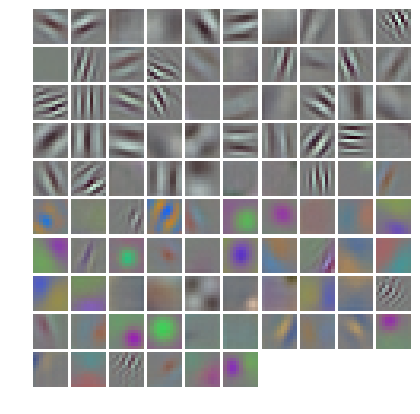

In [141]:
filters = raw_50_ft_caffenet_adam_3000.net.net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

In [326]:
label = 'sign-of-triumph'
# label = 'full-length-portrait'
num_indexes = 30
indexes = np.sort(raw_50_ft_googlenet_adam_35000.scores, order=[label], axis=0)[['idx']][::-1].copy().view('S27')[:num_indexes]
scores = raw_50_ft_googlenet_adam_35000.scores
labels = raw_50_ft_googlenet_adam_35000.labels
test_data = raw_50_ft_googlenet_adam_35000.test_data
num_labels = 5
for index in indexes:
    index_scores = scores[scores['idx'] == index][labels].copy().view('f4')
    top = index_scores.argsort()[::-1][:num_labels]
    top_labels = labels[top]
    if label not in db.metadata[index]['tags']:
        print index
#         raw_50_ft_googlenet_adam_35000.show_top_labels(index)

sx6e4b3b
sy1bcd95
sy1b4cb5
sy6d4400
sp02f04c
sx713a9e
sp27a120
syb22b47
sf09cf57
sx281662
sy1fa403


In [ ]:
raw_50_ft_googlenet_adam_35000.show_top_labels('sy1fa403')

In [325]:
db.metadata['sx281662']['tags']

[u'action', u'joy', u'bicycle-racing']

In [331]:
label = 'automobile-racing'
num_labels = 5
false_negs = []
scores = raw_50_ft_googlenet_adam_35000.scores
labels = raw_50_ft_googlenet_adam_35000.labels
for index in raw_50_ft_googlenet_adam_35000.test_data[label]:
    index_scores = scores[scores['idx'] == index][labels].copy().view('f4')
    top = index_scores.argsort()[::-1][:num_labels]
    top_labels = labels[top]
    if label not in top_labels:
        false_negs.append(index)

In [402]:
fn_labels = []
for index in false_negs:
    fn_labels.extend(db.metadata[index]['tags'])

In [403]:
print Counter(fn_labels)

Counter({u'automobile-racing': 279, u'alone': 72, u'joy': 69, u'motor-sports': 58, u'portrait': 40, u'spectators': 29, u'press-conferences': 22, u'action': 22, u'car-accidents': 18, u'families': 17, u'accidents': 15, u'flags': 14, u'events': 13, u'national-costumes': 11, u'children': 10, u'full-length-portrait': 10, u'the-norwegian-royal-family': 8, u'travel-in-norway': 8, u'caps': 7, u'tires': 7, u'cars': 7, u'tea': 6, u'sports-trophies': 6, u'award-ceremonies': 6, u'kiss': 5, u'supporters': 5, u'television-programmes': 5, u'profile': 5, u'wide-shots': 5, u'handshake': 4, u'night-pictures': 4, u'cross-country-skiing': 4, u'fans': 4, u'racecourse': 4, u'classic-cars': 3, u'bridges': 3, u'drag-racing': 3, u'crowds': 3, u'helmets': 3, u'autographs': 3, u'women': 3, u'aerials': 3, u'gesticulating': 3, u'laughter': 3, u'model-cars': 3, u'opening-ceremonies': 3, u'workshops': 2, u'sky': 2, u'biathlon': 2, u'humorous-pictures': 2, u'competitions': 2, u'the-swedish-royal-family': 2, u'parties

In [411]:
count = 0
for index in set(false_negs):
    if set(db.metadata[index]['tags']).intersection({u'portrait', 'spectators', 'press-conferences', 'full-length-portrait'}):
        count += 1
print count, float(count) / len(false_negs)

96 0.344086021505
